In part 3 we'll use the fact that emissions have yearly pattern. 

Let's load the datasets and compare years (straight lines represent the absence of covid data):

In [1]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_full_original = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
location_group_train = pd.read_csv('new_datasets/train_and_cv_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
train_full_original["Location_group"] = location_group_train
test_original = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK')
location_group_test = pd.read_csv('new_datasets/test_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
test_original["Location_group"] = location_group_test

test_weeks = 49


four_representatives = pd.read_csv('new_datasets/four_representatives.csv', index_col=0)
four_representatives.columns = ["Location"]
four_representatives["Group"] = ['Special 1', 'Special 2', 'High', 'Low']


# Create date feature
train_full_original['date'] = pd.to_datetime(train_full_original.year.astype(str), format='%Y') + \
                     pd.to_timedelta(train_full_original.week_no.mul(7).astype(str) + ' days')
test_original['date'] = pd.to_datetime(test_original.year.astype(str), format='%Y') + \
                     pd.to_timedelta(test_original.week_no.mul(7).astype(str) + ' days')

# Create Location feature
train_full_original["Location"] = train_full_original['latitude'].astype('string') + \
       train_full_original['longitude'].astype('string')
test_original["Location"] = test_original['latitude'].astype('string') + test_original['longitude'].astype('string')

# Pre-covid data
train_precovid_original = train_full_original[train_full_original['date'] < pd.to_datetime('2020-03-18')].copy(deep=True)
precovid_weeks = 53 + len(train_precovid_original[train_precovid_original['year'] == 2020]['week_no'].unique())

# Post-covid data
train_postcovid_original = train_full_original[train_full_original['date'] >  pd.to_datetime('2020-08-26')].copy(deep=True)

# No-covid data
train_nocovid_original = pd.concat([train_precovid_original, train_postcovid_original])

CPU times: total: 2.42 s
Wall time: 3.15 s


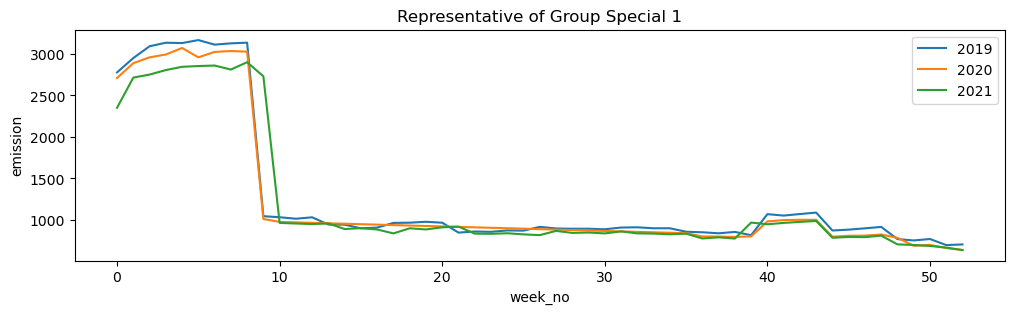

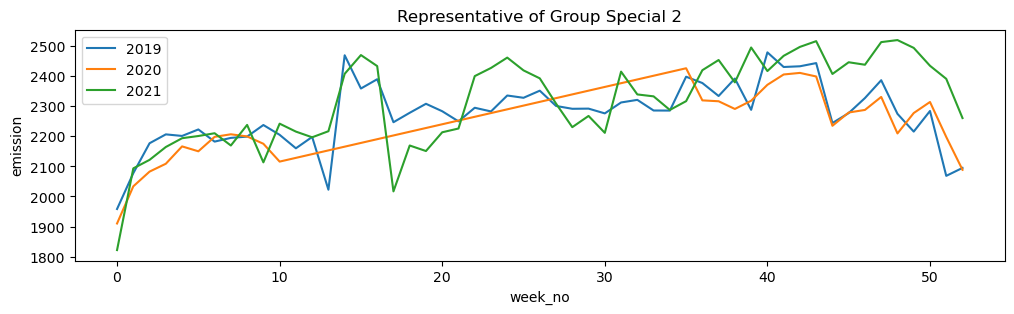

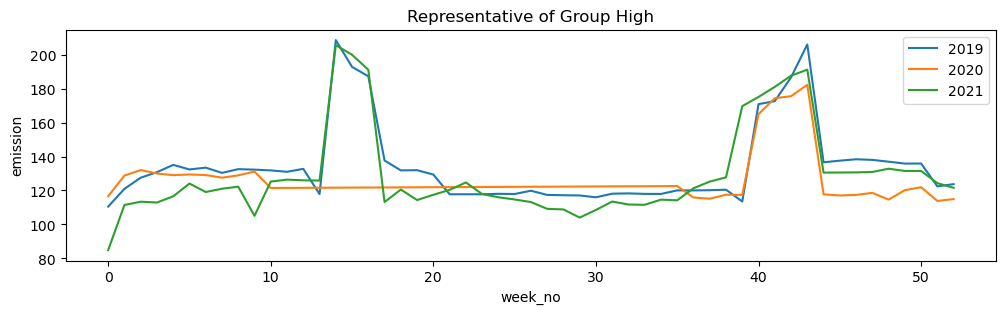

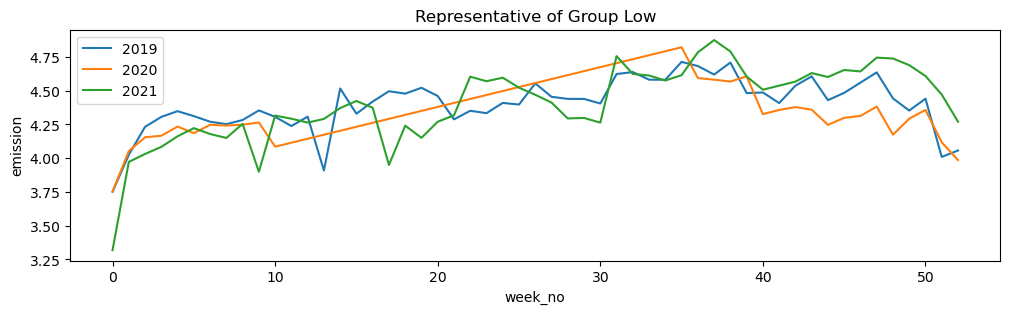

CPU times: total: 1.33 s
Wall time: 2.56 s


In [2]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns


for i, representative in four_representatives.iterrows():
    
    fig, ax = plt.subplots(figsize=(12, 3))
    for year in [2019, 2020, 2021]:
        sns.lineplot(data = train_nocovid_original[(train_nocovid_original["Location"] == representative['Location']) &
                                 (train_nocovid_original['year'] == year)], x='week_no', y='emission', label=year).\
                set(title='Representative of Group {}'.format(representative["Group"]))
    plt.show()

## 00. One year ago

Our first tactic will be forecasting that emissions will be equal to emissions one year ago at the same location (if one year ago was 'the covid period', then we'll take emissions 2 years ago). We won't use 'the covid period' rows.

In [3]:
%%time

study_number = '00'

## Create a pivot table with emissions by year, week_no and location
emissions_by_week = pd.pivot_table(train_nocovid_original, index=['year', 'week_no'], columns='Location', values='emission')


# For the COVID period -- shift one year back.
for w in range(11, 35):
    emissions_by_week.loc[(2020, w), :] = emissions_by_week.loc[(2019, w), :]



## Create the new feature
for i in train_nocovid_original[train_nocovid_original['year'] > 2019].index:
    train_nocovid_original.loc[i, 'OneYearAgo'] = emissions_by_week.loc[(train_nocovid_original.loc[i, 'year'] - 1,
                                                                        train_nocovid_original.loc[i, 'week_no']),
                                                                        train_nocovid_original.loc[i, 'Location']]
for i in test_original.index:
    test_original.loc[i, 'OneYearAgo'] = emissions_by_week.loc[(test_original.loc[i, 'year'] - 1,
                                                                        test_original.loc[i, 'week_no']),
                                                                        test_original.loc[i, 'Location']]
    
test_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 78 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   latitude                                                  24353 non-null  float64       
 1   longitude                                                 24353 non-null  float64       
 2   year                                                      24353 non-null  int64         
 3   week_no                                                   24353 non-null  int64         
 4   SulphurDioxide_SO2_column_number_density                  18211 non-null  float64       
 5   SulphurDioxide_SO2_column_number_density_amf              18211 non-null  float64       
 6   SulphurDioxide_SO2_slant_column_number_density            18211 non-null  float64       
 7   Sul

Let's look at a scatterplot of 'emission' vs. 'OneYearAgo':

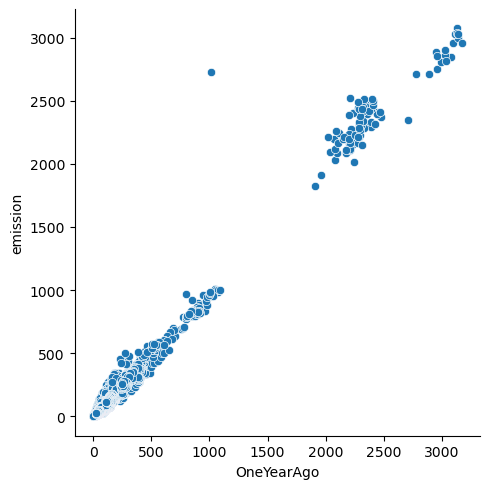

CPU times: total: 266 ms
Wall time: 360 ms


In [4]:
%%time

sns.relplot(data=train_nocovid_original, x='OneYearAgo', y='emission')
plt.show()

Let's test:

In [5]:
%%time

from sklearn.metrics import mean_squared_error

# Create RMSE DataFrame
scores_df = pd.DataFrame({'Comment': [], '2020 RMSE': [], '2021 RMSE': [], 'Test RMSE': []})

prediction_variable = 'OneYearAgo'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable]
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 78.1 ms
Wall time: 377 ms


In [6]:
scores_df.loc[int(study_number), 'Test RMSE'] = 31.65412
scores_df

,Comment,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,14.299684,19.656364,31.65412


## 01. Maximum of previous years

We saw before, that for the most of the locations there is a growing trend. What if we predict that emissions will be maximum of previous years?

In [7]:
%%time

study_number = '01'

prediction_variable = 'Max_train'

## FOR TRAIN SCORES

## Create a pivot table with maximal emissions by week_no and location
max_emissions_by_week = pd.pivot_table(train_full_original[train_full_original['year'] < 2021],
                                                              index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.max)

## Create the new feature
for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable] = max_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]
                                                              


CPU times: total: 9.22 s
Wall time: 12.2 s


Let's look at a scatterplot of 'emission' vs. 'Max':

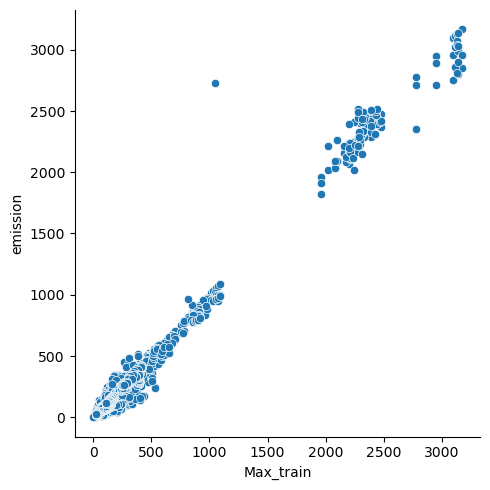

CPU times: total: 312 ms
Wall time: 359 ms


In [8]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable, y='emission')
plt.show()

Let's test:

In [9]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable]
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
    
    
## FOR TEST AND FUTURE PURPOSES 

prediction_variable = 'Max'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable


max_emissions_by_week = pd.pivot_table(train_full_original, index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.max)          

## Create the new feature
for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable] = max_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]                                                                                               
                                                              
for i in test_original.index:
    test_original.loc[i, prediction_variable] = max_emissions_by_week.loc[test_original.loc[i, 'week_no'],
                                                                        test_original.loc[i, 'Location']]

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 11.9 s
Wall time: 16.3 s


In [10]:
scores_df.loc[int(study_number), 'Test RMSE'] = 23.02231
scores_df

,Comment,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,14.299684,19.656364,31.65412
1,Max,14.089696,21.459546,23.02231


## 02 Max with coeffs for groups

Our next strategy will be multiplication of 'Max' by coeffs, 4 different coeffs for 4 different Location groups (see Part 1).

We'll find these coeffs wit hyperparameter tuning in ['studies/3_02.py']('studies/3_02.py') (optimizing for 2021).

In [11]:
study_number = '02'
prediction_variable = 'Max_x_groups'

train_nocovid_original.to_csv('new_datasets/train_3_{}.csv'.format(study_number))

In [12]:
import pickle

with open('studies/3_' + study_number + '_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
    
# print("Best Cross-val RMSE:", study.best_trial.value)
print("Best hyperparameters:", best_params)

Best hyperparameters: {'Special 1': 0.929, 'Special 2': 1.0170000000000001, 'High': 0.936, 'Low': 0.932}


Now, let's apply these coeffs:

In [13]:
## FOR TRAIN SCORES
train_nocovid_original[prediction_variable + '_train'] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Max_train']                          

Let's look at a scatterplot of 'emission' vs. 'Max_multiplied_train', then test:

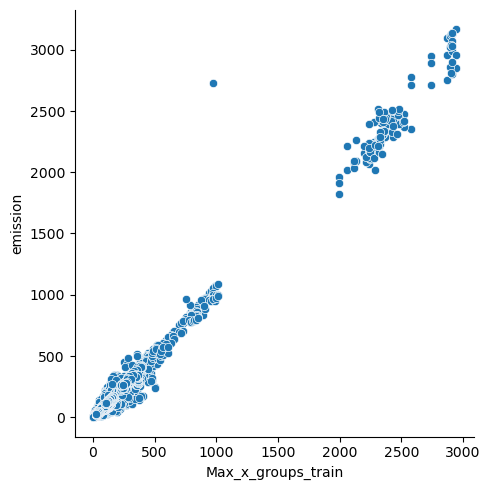

CPU times: total: 266 ms
Wall time: 489 ms


In [14]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable + '_train', y='emission')
plt.show()

In [15]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, 
                                      prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
    
    
## FOR TEST AND FUTURE PURPOSES 


scores_df.loc[int(study_number), 'Comment'] = prediction_variable

## Create the new feature
train_nocovid_original[prediction_variable] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Max']  

test_original[prediction_variable] = test_original['Location_group'].map(best_params) * \
        test_original['Max'] 

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 62.5 ms
Wall time: 76.2 ms


In [16]:
scores_df.loc[int(study_number), 'Test RMSE'] = 21.67107
scores_df

,Comment,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,14.299684,19.656364,31.65412
1,Max,14.089696,21.459546,23.02231
2,Max_x_groups,11.103670,19.188561,21.67107


## 03. Median with coeffs for groups

Note, the coefficients we've found in the study 02 were, mostly, < 1. What if we take medians instead of maximums? We won't use 'the covid period' in calculating medians.

In [17]:
%%time

study_number = '03'

## FOR TRAIN SCORES


## First, let's calculate Median
prediction_variable = 'Median'

# Create a pivot table with maximal emissions by week_no and location
median_emissions_by_week = pd.pivot_table(train_nocovid_original[train_nocovid_original['year'] < 2021],
                                                              index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.median)


for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable + '_train'] = \
                                                median_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]

prediction_variable = 'Median_x_groups'

train_nocovid_original.to_csv('new_datasets/train_3_{}.csv'.format(study_number))


CPU times: total: 15 s
Wall time: 22.3 s


In [18]:
with open('studies/3_' + study_number + '_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
    
# print("Best Cross-val RMSE:", study.best_trial.value)
print("Best hyperparameters:", best_params)

Best hyperparameters: {'Special 1': 0.9420000000000001, 'Special 2': 1.02, 'High': 0.9670000000000001, 'Low': 0.9530000000000001}


Now, let's apply these coeffs:

In [19]:
train_nocovid_original[prediction_variable + '_train'] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Median_train']   

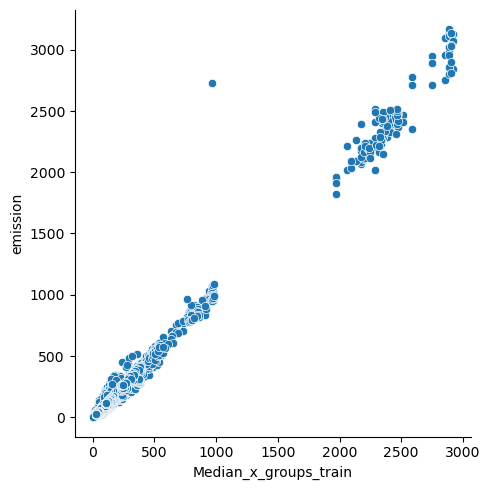

CPU times: total: 266 ms
Wall time: 386 ms


In [20]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable + '_train', y='emission')
plt.show()

In [21]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
    
scores_df.loc[int(study_number), 'Comment'] = prediction_variable


## FOR TEST AND FUTURE PURPOSES 

## First, let's calculate Median
prediction_variable = 'Median'

# Create a pivot table with maximal emissions by week_no and location
median_emissions_by_week = pd.pivot_table(train_nocovid_original,
                                                              index=['week_no'], columns='Location', values='emission',
                                  aggfunc=np.median)


for i in train_nocovid_original.index:
    train_nocovid_original.loc[i, prediction_variable] = \
                                                median_emissions_by_week.loc[train_nocovid_original.loc[i, 'week_no'],
                                                                        train_nocovid_original.loc[i, 'Location']]
    
for i in test_original.index:
    test_original.loc[i, prediction_variable] = median_emissions_by_week.loc[test_original.loc[i, 'week_no'],
                                                                        test_original.loc[i, 'Location']]

## Now, create the new feature
prediction_variable = 'Median_x_groups'

train_nocovid_original[prediction_variable] = train_nocovid_original['Location_group'].map(best_params) * \
        train_nocovid_original['Median']   
 
test_original[prediction_variable] = test_original['Location_group'].map(best_params) * \
        test_original['Median'] 

# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
                           'emission': test_original[prediction_variable]})

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 12.2 s
Wall time: 15.5 s


In [22]:
scores_df.loc[int(study_number), 'Test RMSE'] = 35.27105
scores_df

,Comment,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,14.299684,19.656364,31.65412
1,Max,14.089696,21.459546,23.02231
2,Max_x_groups,11.103670,19.188561,21.67107
3,Median_x_groups,7.043665,17.888637,35.27105


Strangely, test results for Median_x_groups are much worse, than for Max_x_groups.

## 04. Max with coeffs based on features

Next strategy we'll try will be to calculate a separate 'Max' scaling coefficient for each Location-week_no combination. This coefficient will be a median of growth factors of all features for that combination:

In [23]:
%%time

study_number = '04'

prediction_variable = 'Max_x_features'

scores_df.loc[int(study_number), 'Comment'] = prediction_variable

## For technical purposes, create a new feature: Location_week_no
train_nocovid_original['Location_week_no'] = train_nocovid_original['Location'] + '_' + \
                                                train_nocovid_original['week_no'].astype('str')
test_original['Location_week_no'] = test_original['Location'] + '_' \
                                        + test_original['week_no'].astype('str')

## FOR TRAIN SCORES

# Past years' maximums of features for each week and location
max_by_week = pd.pivot_table(train_nocovid_original[train_nocovid_original['year'] < 2021],
                                                              index=['Location_week_no'],
           values=train_nocovid_original.columns.difference(['latitude', 'longitude', 'year', 'week_no', 'emission',
                    'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
                                                            'Max_x_groups', 'Location_week_no',
                                                            'Median_train', 'Median', 'Median_x_groups_train',
                                                            'Median_x_groups']),
                                  aggfunc=np.max)



# Values of features for each week and location
last_by_week = pd.pivot_table(train_nocovid_original[train_nocovid_original['year'] == 2021],
                                                              index=['Location_week_no'],
           values=train_nocovid_original.columns.difference(['latitude', 'longitude', 'year', 'week_no', 'emission',
                    'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
                                                            'Max_x_groups', 'Location_week_no',
                                                            'Median_train', 'Median', 'Median_x_groups_train',
                                                            'Median_x_groups']))


# Growth factors of features for each week and location
feature_growth = last_by_week.sort_index() / max_by_week.sort_index()

# Median growth factor of features for each week and location
median_growth = feature_growth.median(axis=1)

## Create the new feature
train_nocovid_original[prediction_variable + '_train'] = train_nocovid_original['Max_train'] * \
                train_nocovid_original['Location_week_no'].map(median_growth)
                                
## Fill the rows without observations with original values
train_nocovid_original.loc[train_nocovid_original[prediction_variable + '_train'].isna(), prediction_variable + '_train'] = \
        train_nocovid_original.loc[train_nocovid_original[prediction_variable + '_train'].isna(), 'Max_train']



CPU times: total: 250 ms
Wall time: 326 ms


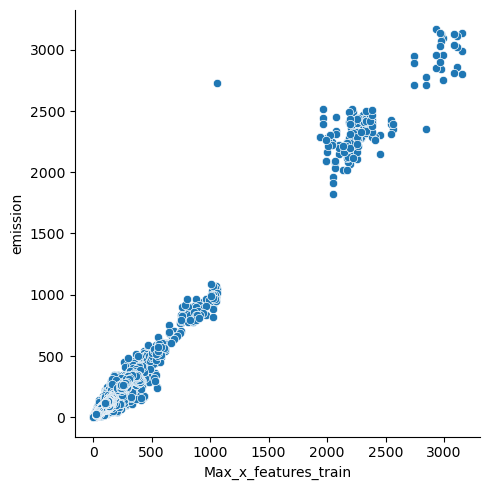

CPU times: total: 312 ms
Wall time: 367 ms


In [24]:
%%time

sns.relplot(data=train_nocovid_original, x=prediction_variable + '_train', y='emission')
plt.show()

In [25]:
%%time

# Calculate train RMSEs
for year in [2020, 2021]:
    emission = train_nocovid_original.loc[train_nocovid_original['year'] == year, 'emission']
    pred = train_nocovid_original.loc[train_nocovid_original['year'] == year, prediction_variable + '_train']
    score = mean_squared_error(emission, pred, squared=False)
    scores_df.loc[int(study_number), str(year) + ' RMSE'] = score
    
## FOR TEST AND FUTURE PURPOSES (TODO)


# # Past years' maximums of features for each week and location
# max_by_week = pd.pivot_table(train_nocovid_original, index=['Location_week_no'],
#            values=train_nocovid_original.columns.difference(['latitude', 'longitude', 'year', 'week_no', 'emission',
#                     'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
#                                                             'Max_x_groups', 'Location_week_no', 'Max_x_features_train']),
#                                   aggfunc=np.max)

# # Values of features for each week and location
# last_by_week = pd.pivot_table(test_original, index=['Location_week_no'],
#            values=test_original.columns.difference(['latitude', 'longitude', 'year', 'week_no',
#                     'Location_group', 'date', 'Location', 'OneYearAgo', 'Max_train', 'Max', 'Max_x_groups_train',
#                                                             'Max_x_groups', 'Location_week_no']))

# # Growth factors of features for each week and location
# feature_growth = last_by_week / max_by_week

# # Median growth factor of features for each week and location
# median_growth = feature_growth.median(axis=1)

# ## Create the new feature
# train_nocovid_original[prediction_variable] = train_nocovid_original['Max'] * \
#                 train_nocovid_original['Location_week_no'].map(median_growth)
# test_original[prediction_variable] = test_original['Max']  * \
#                  test_original['Location_week_no'].map(median_growth)


# ## Fill the rows without observations with original values
# train_nocovid_original.loc[train_nocovid_original[prediction_variable].isna(), prediction_variable] = \
#         train_nocovid_original.loc[train_nocovid_original[prediction_variable].isna(), 'Max']
# test_original.loc[test_original[prediction_variable].isna(), prediction_variable] = \
#         test_original.loc[test_original[prediction_variable].isna(), 'Max']
                            

# # Prepare submission file
# submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_original.index, \
#                            'emission': test_original[prediction_variable]})

# submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 0 ns
Wall time: 7.59 ms


In [26]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,2020 RMSE,2021 RMSE,Test RMSE
0,OneYearAgo,14.299684,19.656364,31.65412
1,Max,14.089696,21.459546,23.02231
2,Max_x_groups,11.103670,19.188561,21.67107
3,Median_x_groups,7.043665,17.888637,35.27105
4,Max_x_features,13.270579,22.794264,NaN


In [27]:
train_nocovid_original.to_csv('new_datasets/train_3_final.csv')
test_original.to_csv('new_datasets/test_3_final.csv')